# Machine Learning - Practical 2

Names: Smit Patel, Nishtha agarwal, Daria bilich

In [1]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.

In [2]:
file = '/data/Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

### Tasks 1.1: Dataset Exploration 

Let's start with a bit of exploration.

- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.

In [3]:
# data exploration
print(f'Number of samples {len(df)} and have {X_all.shape[1]} feature')

Number of samples 1080 and have 64 feature


In [4]:
print(f'Number of label is {len(df["Behavior"].unique())} ')

Number of label is 2 


In [5]:
df.iloc[::N,1:65].describe().iloc[[3,7]]

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N
min,0.168493,0.292269,0.198159,1.564858,1.991141,0.121545,0.124793,1.555075,0.134882,0.790958,...,0.117840,0.114111,0.125190,0.087666,0.129296,0.082373,0.296247,0.220444,0.971291,1.512936
max,2.480316,2.488684,0.446958,3.174743,6.465180,0.327952,0.247874,7.464070,0.294838,4.497337,...,0.199183,0.260739,0.567127,0.155700,0.304341,0.187461,0.722240,0.356958,2.454891,2.793027


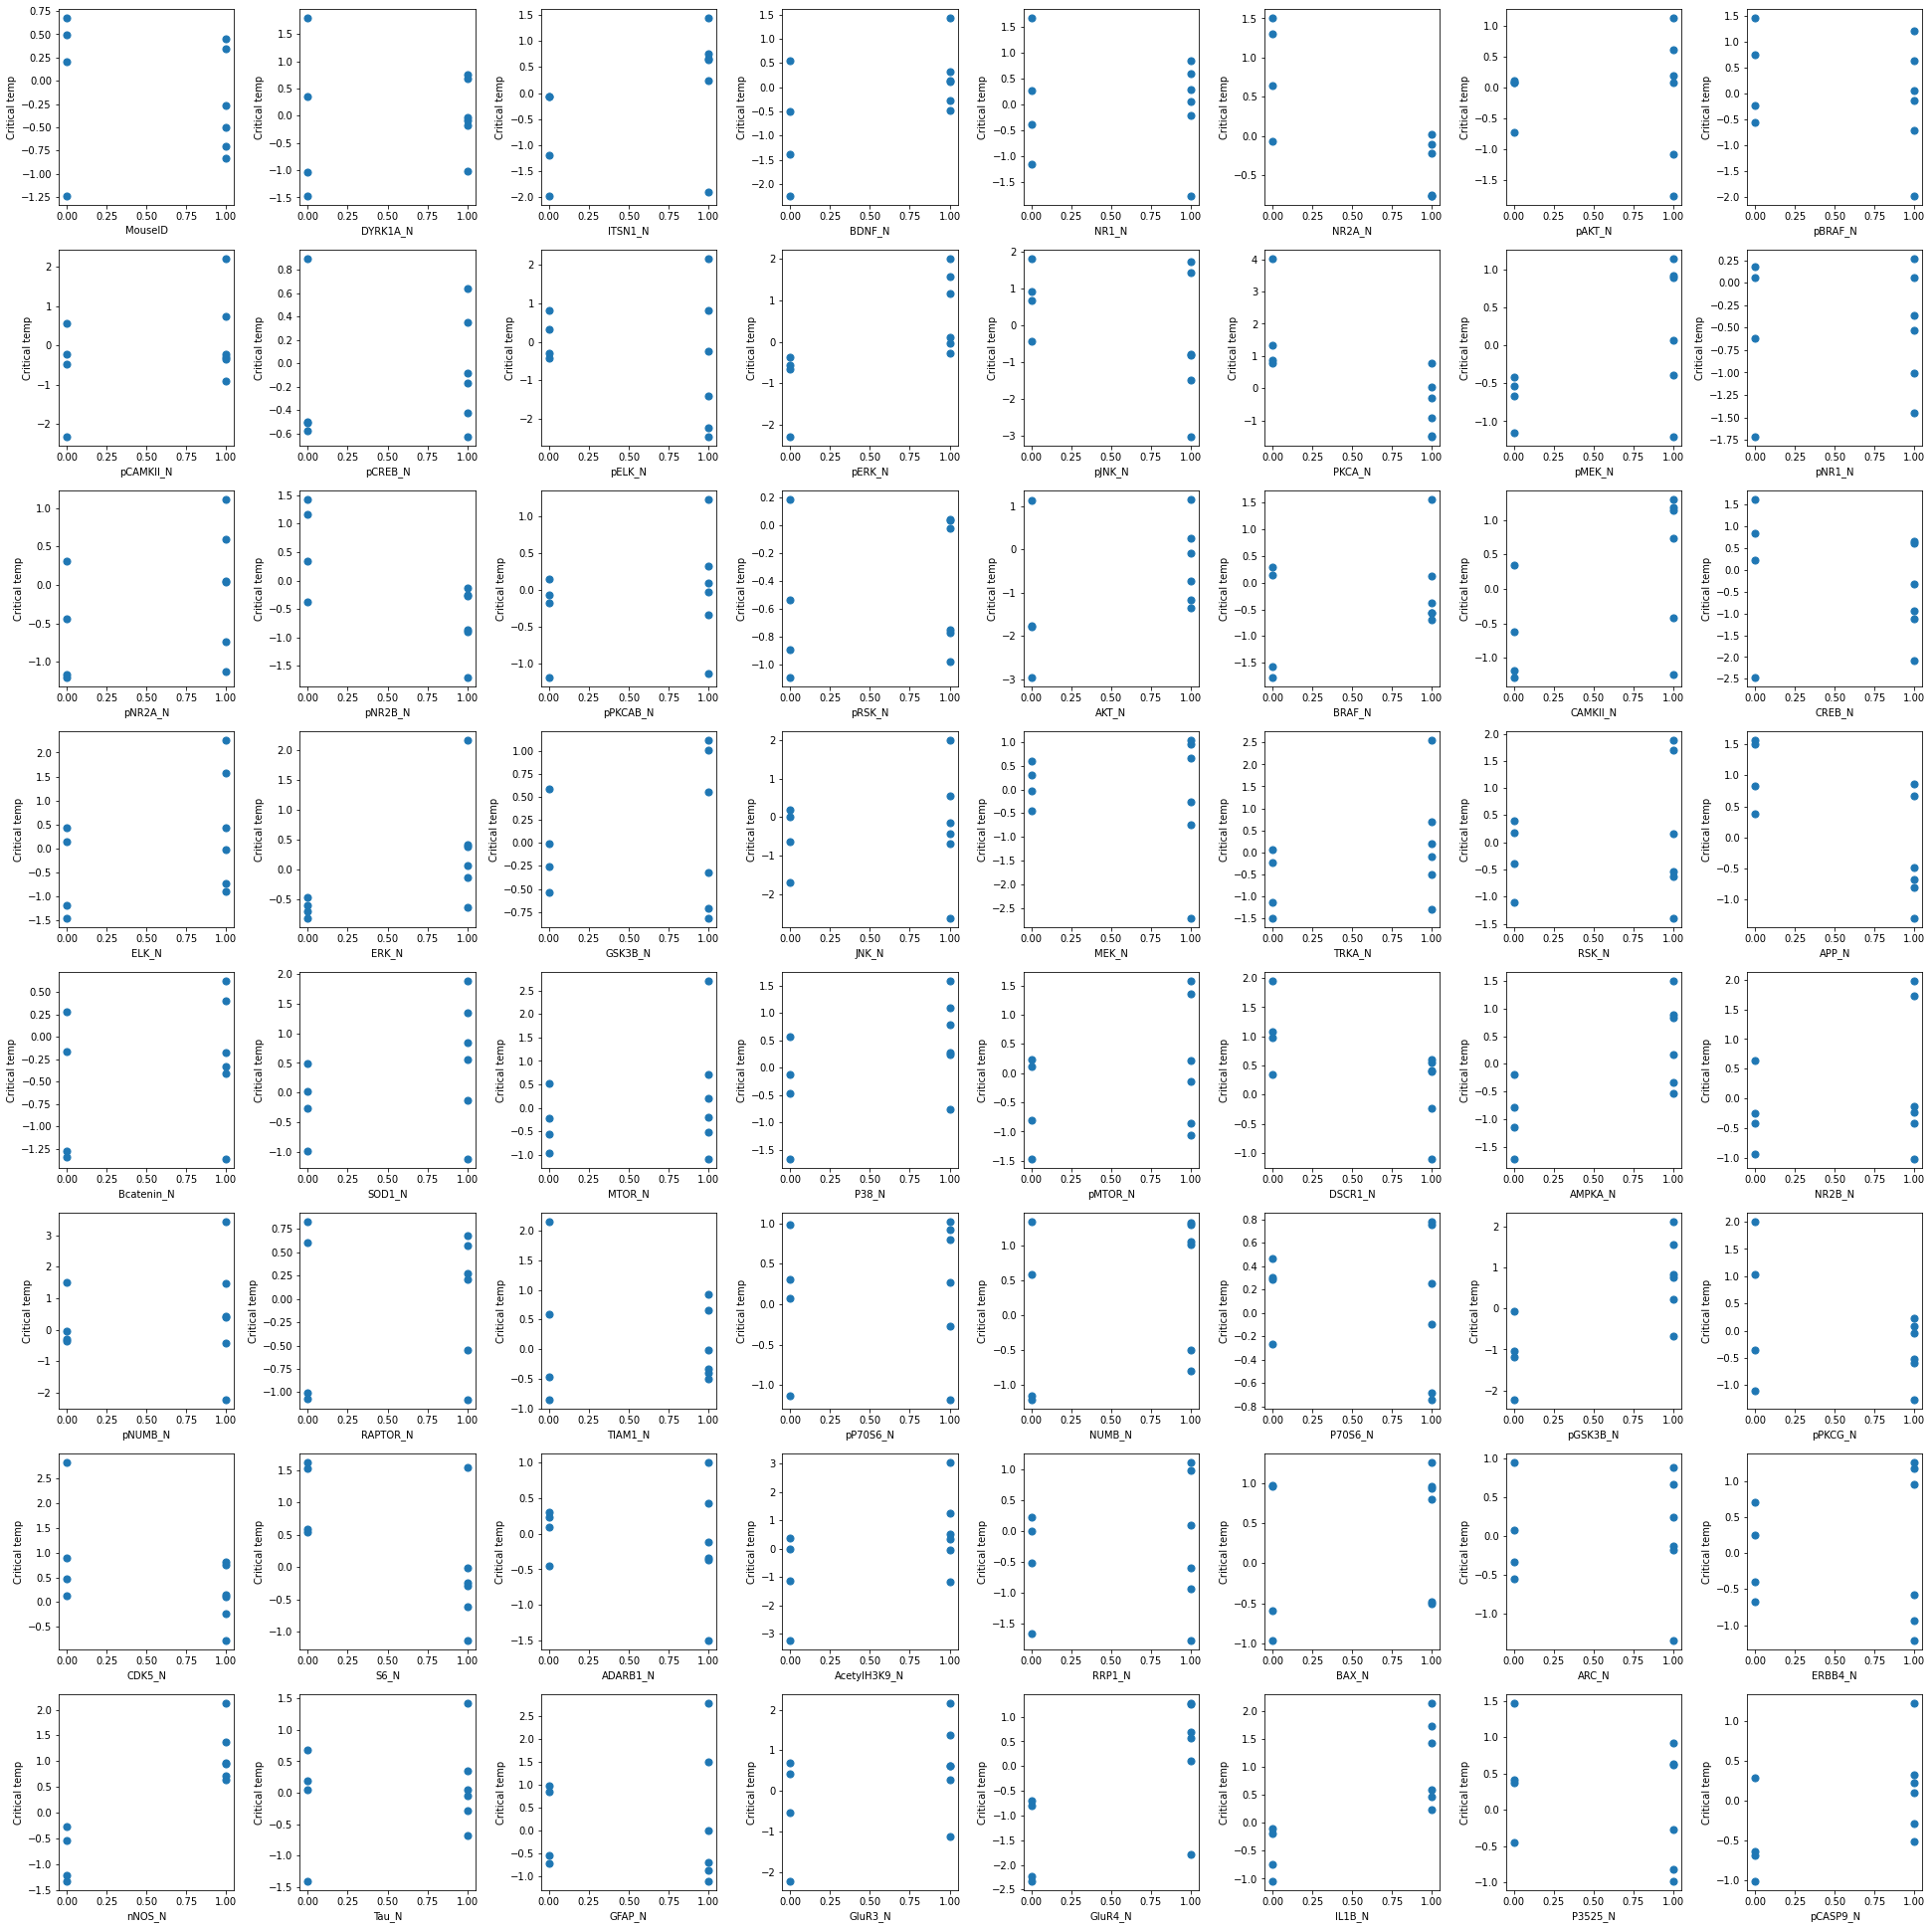

In [48]:
First_10 = pd.DataFrame(X_all).head(10).to_numpy()
first_label = pd.DataFrame(t_all).head(10).to_numpy()
fig , ax = plt.subplots(8,8, figsize=(27,27))
count = 0
columns = df.columns
for i in range(8):
  for j in range(8):
    ax[i][j].scatter(first_label,First_10[: , count], s=50, alpha=1)
    ax[i][j].set(ylabel='Critical temp' , xlabel=columns[count])
    count += 1
plt.tight_layout()
plt.show()

Text(0, 0.5, 'frequency')

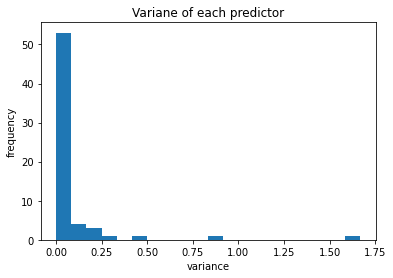

In [19]:
Xvar = (df.iloc[::,1:65]).dropna().to_numpy().var(axis=0)
plt.hist(Xvar, bins=20)
plt.title('Variane of each predictor')
plt.xlabel('variance')
plt.ylabel("frequency")

**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [8]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # ---------------- INSERT CODE ----------------------
    indices = np.random.choice( len(X), int((1-frac)*len(X)), replace=False )
    X_train = X[indices]
    y_train = y[indices]

    indices = list((set(range(len(X))) - set(indices)))
    X_test = X[indices]
    y_test = y[indices]

    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test
    
    
def preprocess(X, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # ---------------- INSERT CODE ----------------------
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)
    X = (X - x_mean) / x_std
    # ---------------- END CODE -------------------------
    
    return X

In [9]:
X_train, X_test, y_train, y_test = split_data(X_all, t_all, seed=42)
X_train = preprocess(X_train, 42)
X_test = preprocess(X_test, 42)

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

### Task 2.1

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

Text(0.5, 0, 'predictors')

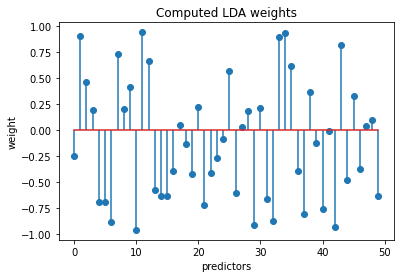

In [10]:
# example usage of stemplot
w_lda = np.random.uniform(-1, 1, 50)  # example data
plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

In [11]:
def compute_lda_weights(x, y, alpha=0.001):
    '''function that computes regularized LDA weights for a two class problem

    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float

    output:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''

    # ---------------- INSERT CODE ----------------------
    x0 = x[y]
    x1 = x[~y]
    m0 = x0.mean(axis=0)
    m1 = x1.mean(axis=0)
    mdiff = np.subtract(np.array(m0),np.array(m1))
    w = alpha*mdiff

    # ---------------- END CODE -------------------------

    return m0, m1, mdiff, w

In [12]:
# split dataset and apply LDA
X_train, X_test, y_train, y_test = split_data(X_all, t_all,seed = 42)
X_train = preprocess(X_train,seed = 42)
X_test = preprocess(X_test, seed = 42)

m0, m1, mdiff, w = compute_lda_weights(X_train, y_train, alpha=0.001)

Text(0.5, 0, 'predictors')

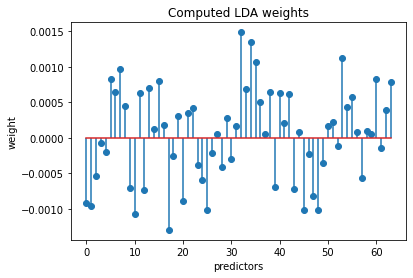

In [13]:
# visualize LDA weights using stemplot
plt.stem(w.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

### Task 2.2

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

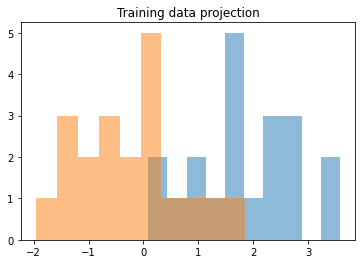

In [14]:
# example usage of histogram
a, b = np.random.normal(2, 1, 20), np.random.normal(0, 1, 20)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)

In [15]:
# compute projections for training and test data
p_train = np.dot(np.transpose(w),np.transpose(X_train))
p_test = np.dot(np.transpose(w),np.transpose(X_test))
p_train

array([-9.70923200e-03, -1.03612269e-02, -1.42995309e-02,  1.19837400e-02,
        1.16125430e-02, -2.78919812e-03,  1.85320064e-03,  1.80975150e-02,
       -5.30671334e-03, -1.61567676e-02,  1.49607423e-02,  8.54567226e-05,
       -2.06506036e-02,  4.07892724e-03,  1.94709173e-02, -4.57413694e-03,
        1.18397873e-02, -1.35751531e-02, -1.39484691e-02,  8.58231080e-03,
        7.55529197e-03, -1.40457820e-02,  2.92205891e-02,  1.99996410e-02,
        1.41956647e-02,  1.37770943e-02,  1.47529934e-02,  1.76042915e-02,
       -1.22162684e-02, -1.05012945e-02, -1.98470913e-02, -4.94311424e-03,
        5.07742043e-03,  1.33207473e-02,  1.89062415e-02,  2.38863514e-02,
       -5.92503922e-03, -1.81092966e-02, -1.44562028e-02, -1.83883253e-02,
       -3.88886248e-02,  2.32578236e-02, -2.02103936e-02, -5.01298781e-02,
        6.04774469e-03,  1.72799100e-02,  1.36444802e-02,  1.82127968e-02,
        1.36338593e-02,  8.63181656e-03, -3.38370148e-02,  1.47939238e-02,
        1.68008628e-02,  

(array([2., 2., 0., 2., 1., 3., 2., 2., 1., 1.]),
 array([-0.02775985, -0.02475107, -0.02174229, -0.01873351, -0.01572473,
        -0.01271595, -0.00970716, -0.00669838, -0.0036896 , -0.00068082,
         0.00232796]),
 <a list of 10 Patch objects>)

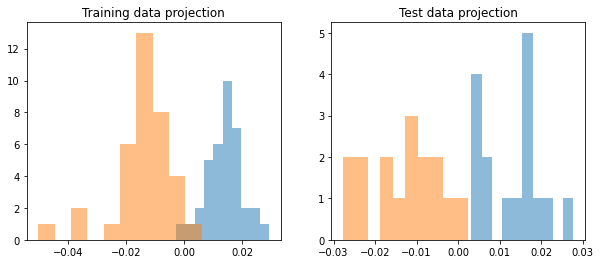

In [16]:
# visualize projections using histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Training data projection')
axes[0].hist(p_train[y_train],label='class 0',alpha=0.5)
axes[0].hist(p_train[~y_train],label='class 1',alpha=0.5)

axes[1].set_title('Test data projection')
axes[1].hist(p_test[y_test],label='class 0',alpha=0.5)
axes[1].hist(p_test[~y_test],label='class 1',alpha=0.5)

### Task 2.3

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

In [22]:
def compute_threshold_LDA(m0, m1, w):
    '''Compute the optimal threshold for LDA .

    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)

    output:
        c: the optimal threshold for LDA 
    '''

    # ---------------- INSERT CODE ----------------------
    
    c = np.dot(w,1/2*np.add(m0,m1))
    
    # ---------------- END CODE -------------------------
  
    return c


def score_LDA(x_proj, y, c):
    '''Compute the accuracy given a threshold.

    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar

    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        acc: classification accuracy
    '''
    # ---------------- INSERT CODE ----------------------
    y_hat = []
    acc = 0
    for xi,class_label in zip(x_proj,y):
        class_label_pred = xi>=c
        y_hat.append(class_label_pred)
        if class_label_pred == class_label:
            acc += 1
    acc /= len(x_proj) /100


    # ---------------- END CODE -------------------------
    
    return y_hat, acc

In [23]:
# compute optimal threshold
c = compute_threshold_LDA(m0, m1, w)
c

-0.00019068909904458624

In [24]:
# compute classification accuracy
y_hat_train, acc_train = score_LDA(p_train, y_train , c)
print(acc_train)
print('error_train =', 100 - acc_train)
y_hat_test, acc_test = score_LDA(p_test, y_test , c)
print(acc_test)
print('error_test =', 100 - acc_test)

95.89041095890411
error_train = 4.109589041095887
96.875
error_test = 3.125


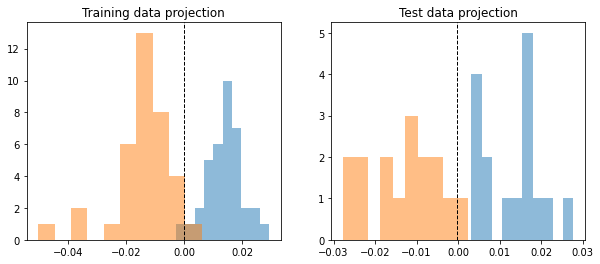

In [25]:
# visualize treshold in histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Training data projection')
axes[0].hist(p_train[y_train],label='class 0',alpha=0.5)
axes[0].hist(p_train[~y_train],label='class 1',alpha=0.5)
axes[0].axvline(c, color='k', linestyle='dashed', linewidth=1)

axes[1].set_title('Test data projection')
axes[1].hist(p_test[y_test],label='class 0',alpha=0.5)
axes[1].hist(p_test[~y_test],label='class 1',alpha=0.5)
axes[1].axvline(c, color='k', linestyle='dashed', linewidth=1)

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [26]:
X_all, t_all = pickle.load(open('/data/cnn_features.pickle', 'rb'))

### Task 3.0: Normalize and split the data

Make sure the data has has zero mean and variance 1 per feature.

In [27]:
# normalize data
X_all = preprocess(X_all, 42)
X_train, X_test, y_train, y_test = split_data(X_all, t_all, seed=42)

### Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  

    Hints:  
    (a) There is a bias term in logistic regression  
    (b) Use a small value for weight init to avoid numerical problems.


2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

In [28]:
# IRLS
import math
def sigmoid(X_all, w):
  return 1/(1 + np.exp(-np.dot(X_all, w)))
def R(y):
    R = np.identity(y.size)
    R = R * (y * (1 - y))
    return R
def irls(X_all, t_all):
  w = np.full(X_all.shape[1], 0.01)
  w = w.reshape(w.size, 1)
  t_all = np.array(list(map(lambda x: 1 if x else 0, t_all)))
  t_all = t_all.reshape(t_all.size, 1)
  #print(t_all)
  for i in range(25):
    y = sigmoid(X_all, w)
    w_new = w - np.dot(np.dot(np.linalg.inv(np.dot(np.dot(X_all.T,R(y)), X_all)), X_all.T), (y - t_all))
  return w_new

weights = irls(X_train, y_train)
weights.shape

(256, 1)

In [29]:
y_pred = np.dot(weights.T, X_test.T).T
new_pred_y = []
for x in y_pred:
  if x > 0.5:
    x = 1
  else:
    x = 0
  new_pred_y.append(x)
accu = (new_pred_y == y_test).sum() / len(y_test)
accu

0.8816666666666667

In [30]:
def logreg(X_all, t_all):
  # w = np.ones(X_all.shape[1])
  # w = w.reshape(w.size, 1)
  # y2 = sigmoid(X_all, w)
  # y2 = (y2 - t_all)
  log_reg = LogisticRegression(penalty='none').fit(X_train, y_train)
  return log_reg

model = logreg(X_train, y_train)
weights = model.coef_
model.score(X_test, y_test)

0.8816666666666667

### Task 3.2: Logistic Regression with Regularization

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [43]:
c = np.linspace(0.02, 1, 25)
accu_l1 = []
accu_l2 = []
def logreg_l1(X_train, y_train, reg):
  logreg_l1 = LogisticRegression(penalty='l1', C=reg, solver='saga').fit(X_train, y_train)
  return logreg_l1
# may be it's better to use solver='liblinear'?'
def logreg_l2(X_train, y_train, reg):
  logreg_l2 = LogisticRegression(penalty='l2', C=reg).fit(X_train, y_train)
  return logreg_l2

for i in range(25):
  model_l1 = logreg_l1(X_train, y_train, c[i])
  accu_l1.append(model_l1.score(X_test, y_test))

for i in range(25):
  model_l2 = logreg_l2(X_train, y_train, c[i])
  accu_l2.append(model_l2.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

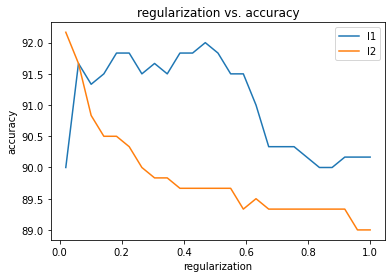

In [44]:
plt.plot(c, list(map(lambda x: x * 100, accu_l1)) , label='l1')
plt.plot(c, list(map(lambda x: x * 100, accu_l2)), label='l2')
plt.title('regularization vs. accuracy')
plt.xlabel('regularization')
plt.ylabel('accuracy')
plt.legend()
plt.show()